### Helper functions

In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline

def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

def reshape(img):
    return np.reshape(img, (image_width, image_height))

def plot_results(input_imgs, output_imgs):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(reshape(input_imgs[i+10]), cmap='gist_yarg')
        ax.axis('off')

    for i in range(1, 6):
        ax = fig.add_subplot(2, 5, i)
        plt.imshow(reshape(output_imgs[i+10]), cmap='gist_yarg')
        ax.axis('off') 

def filenames_to_labels(filenames, folder):
    labels = []
    for file in filenames:
        file = file.split("(")[0].lstrip(folder)
        label = "".join(_ for _ in file if _ in "123456789")
        labels.append(int(label))
    return labels

### Read and resize dataset

In [2]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import os
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames = sorted(filenames)[1:]

image_width = 200
image_height = 200

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)
raw_labels = []

i = 0
for file in filenames:
    try:
        image = load_and_normalise(file)
        to_crop = (image.shape[0]-image_width)/2
        image_resized = crop(image, (to_crop, to_crop))
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

labels = filenames_to_labels(filenames, folder)

In [3]:
def even_round(num):
    return round(num/2.)*2

def dataset_split(dataset, labels, test_size=0.2):
    test_size = even_round(len(dataset)*test_size)
    x_train, x_test = dataset[:-test_size], dataset[-test_size:]
    y_train, y_test = labels[:-test_size], labels[-test_size:]
    return x_train, x_test, y_train, y_test

# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

### Build autoencoder model

In [15]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [18]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 64)      1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 16)      4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0   

In [19]:
model = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [20]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

In [21]:
encoded_imgs[0].shape

(40000,)

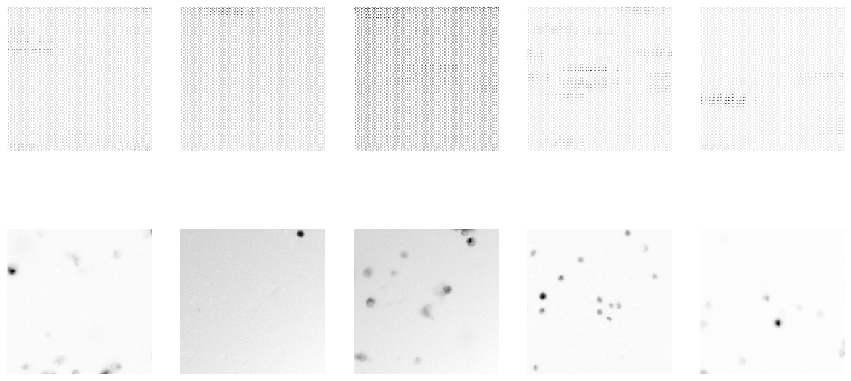

In [12]:
plot_results(x_test, encoded_imgs)

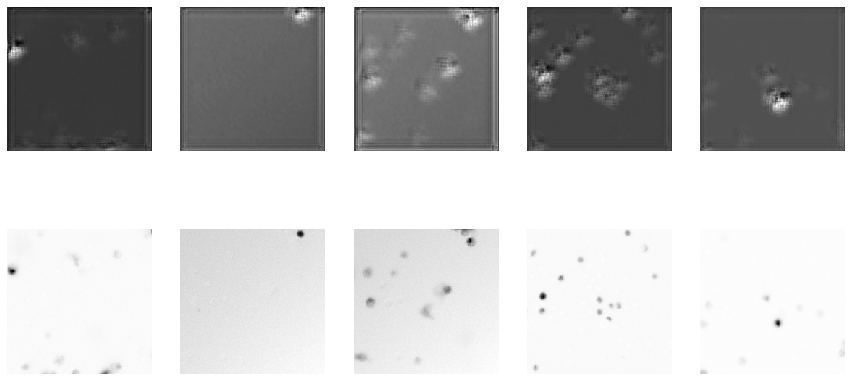

In [7]:
plot_results(x_test, decoded_imgs)

### Calculate overlap between images

In [173]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, image_width, image_height), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        o = reshape(np.abs(dcell-tcell))
        overlaps[y] = o
        overlap_labels.append(labels[y])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(x_train, y_train)

def label_to_colourmap(labels):
    lmap = {}
    for label in labels:
        print(label)
        if label in [1, 2, 3, 4, 5, 6, 7, 8, 12, 24]:
            print("black")
            lmap[label] = 'b'
        elif label in [9, 10, 11, 13, 14, 15, 23]:
            lmap[label] = 'y'
        elif label in [16, 17, 18, 19, 20, 21, 22]:
            lmap[label] = 'r'
        else:
            lmap[label] = 'k'
    return lmap

### Clustering algorithm

In [175]:
# Imports
from sklearn.datasets.samples_generator import make_blobs

# Generate 2D data points
X, _ = make_blobs(n_samples=10, centers=3, n_features=2,
                 cluster_std=0.2,  random_state=0)

In [177]:
X

array([[ 1.00507879,  4.59464203],
       [ 1.12847762,  4.32812233],
       [ 2.11788106,  0.72684451],
       [ 0.95562631,  4.38590703],
       [-1.35401677,  2.76944926],
       [-1.07295309,  2.62700913],
       [-2.03750198,  3.04860598],
       [ 2.35408334,  0.85663201],
       [ 2.14404017,  0.96439853],
       [ 1.16628776,  4.27351589]])

In [178]:
x_overlap

array([[[0.48046875, 0.4609375 , 0.48828125, ..., 0.53515625,
         0.56640625, 0.44921875],
        [0.41015625, 0.4609375 , 0.39453125, ..., 0.66796875,
         0.60546875, 0.46875   ],
        [0.484375  , 0.49609375, 0.4765625 , ..., 0.98828125,
         0.8359375 , 0.7421875 ],
        ...,
        [0.37890625, 0.40234375, 0.48046875, ..., 0.375     ,
         0.38671875, 0.453125  ],
        [0.48046875, 0.40234375, 0.4375    , ..., 0.4375    ,
         0.3984375 , 0.4375    ],
        [0.4609375 , 0.44921875, 0.44140625, ..., 0.41796875,
         0.3984375 , 0.44140625]],

       [[0.36328125, 0.35546875, 0.37890625, ..., 0.359375  ,
         0.43359375, 0.29296875],
        [0.36328125, 0.40234375, 0.40234375, ..., 0.390625  ,
         0.37890625, 0.37890625],
        [0.3359375 , 0.3984375 , 0.35546875, ..., 0.3359375 ,
         0.33203125, 0.34765625],
        ...,
        [0.296875  , 0.38671875, 0.33984375, ..., 0.32421875,
         0.359375  , 0.33984375],
        [0.3

In [169]:
# try k-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=11).fit(x_overlap)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5, learning_rate=11)
clusters = tsne.fit_transform(encoded_imgs)

In [27]:
clusters.shape

(118, 2)

In [28]:
overlaps.shape

NameError: name 'overlaps' is not defined

In [29]:
lmap = label_to_colourmap()

NameError: name 'label_to_colourmap' is not defined

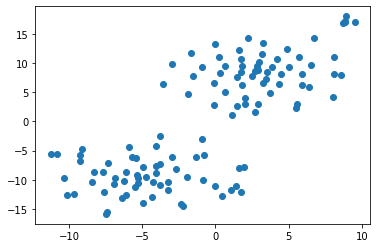

In [32]:
plt.scatter(clusters[:,0], clusters[:,1])

### View filters; code snippets

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1